<a href="https://colab.research.google.com/github/goerlitz/nlp-classification/blob/main/notebooks/10kGNAD/colab/21d_10kGNAD_optuna_trial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of Optuna Studies and Trials

Aggregates and displays studies and trials found in a optuna database 

**Overview of all Studies**
* trial states and hyperparam distribution settings
* visualization of best trials

**Study Details**
* parallel plot of hyperparameters
* hyperparameter importance
* evaluation metrics plots
* training progress

# Prerequisites

## Connect Google Drive

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Database Connection

In [2]:
db_path = "/content/gdrive/My Drive/Colab Notebooks/nlp-classification/"
db_name = "10kgnad_optuna"
storage = f"sqlite:///{db_path}{db_name}.db"

## Install Libraries

In [3]:
!pip install -q --upgrade optuna >/dev/null

## Study Information

In [4]:
import numpy as np
import pandas as pd
import optuna
from optuna.storages import RDBStorage
from optuna.trial import TrialState
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

# adjust style
mpl.style.use("seaborn-notebook")
mpl.rcParams["figure.figsize"] = (6,4)
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["axes.grid"] = True
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['patch.linewidth'] = 1.0  # also affects legend border


class StudyInfo:

    def __init__(self, storage: str):
        self.storage = RDBStorage(url=storage)
        self._trials_df = None
        self.name_map = {"num_train_epochs": "epochs",
                         "per_device_train_batch_size": "bs",
                         "batch_size": "bs"}

    def dist2str(self, dist: optuna.distributions.BaseDistribution) -> str:
        """Create string representation for parameter distributions."""
        if isinstance(dist, optuna.distributions.UniformDistribution):
            return f"{dist.low} -> {dist.high}"
        if isinstance(dist, optuna.distributions.LogUniformDistribution):
            return f"{dist.low} -> {dist.high} (log)"
        if isinstance(dist, optuna.distributions.CategoricalDistribution):
            return f"{list(dist.choices)}"
        else:
            return str(dist)
    
    def study_details(self) ->pd.DataFrame:
        """List all hyperparameters for each study."""

        study_info = []
        study_states = []
        study_dist = []

        for s in optuna.get_all_study_summaries(storage):
            name = s.study_name
            info = {"study_name": name,
                    "start": "???" if s.datetime_start is None else s.datetime_start.date(),
                    "directions": len(s.directions)}
            study_info.append(info)

            study = optuna.load_study(name, storage)
            states = pd.Series([t.state for t in study.get_trials()]).value_counts()
            counts = {str(state).split(".")[1]:count for state, count in states.items()}
            study_states.append(counts)

            dist = study.get_trials()[0].distributions
            dist = {self.name_map.get(k, k):dist[k] for k in dist.keys()} # rename keys
            dist = {k:self.dist2str(dist[k]) for k in dist.keys()}
            study_dist.append(dist)

        return (pd.concat([pd.DataFrame(study_info),
                           pd.DataFrame(study_states).fillna(0).astype(int),
                           pd.DataFrame(study_dist)
                          ], axis=1).
                fillna("--").
                set_index("study_name").
                sort_values("study_name")
                )
    
    def _colors(self, pal: "ColorMap", n=10):
        """Create a list of n colors using the given colormap."""
        norm = mpl.colors.Normalize(vmin=0, vmax=n-1)
        return [pal(norm(i)) for i in range(0,n)]

    def show_best_trials(self, name=None, metrics=["eval_loss", "eval_f1"], figsize=None):
        """Visualization of best trials from all studies."""

        best_trials = []
        for s in optuna.get_all_study_summaries(self.storage):
            if name is not None and name not in s.study_name:
                continue

            best_trials.append(self
                               .get_best_trials(s.study_name)
                               .assign(study_name=s.study_name)
                               .rename(columns=self.name_map)
                               )
        best_trials_df = pd.concat(best_trials)

        title = "Performance of Best Study Trials"

        n=20
        fig, ax = plt.subplots(figsize=figsize)
        pal = self._colors(mpl.cm.tab20, n)

        for i, s in enumerate(sorted(best_trials_df.study_name.unique())):
            df = best_trials_df[lambda x: x["study_name"] == s]
            ax.scatter(df[metrics[0]], df[metrics[1]], label=s, color=pal[i%n])
        
        ax.grid(axis='y', linestyle='--', zorder=0)
        ax.grid(axis='x', linestyle=':', zorder=0)


        # ax = plt.gca()
        # ax.add_patch(Ellipse(xy=(0.371, 0.877), width=0.01, height=0.02, edgecolor='gray', fc='None', lw=1.5))
        # ax.add_patch(Ellipse(xy=(0.372, 0.904), width=0.01, height=0.015, edgecolor='gray', fc='None', lw=1.5))

        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        ax.set_xlabel(metrics[0])
        ax.set_ylabel(metrics[1])
        ax.set_title(title)

        fig.tight_layout()
        return fig

    def _extract_metrics(self, t: optuna.Trial):
        """extract metrics stored in user attributes."""

        attrs = t.user_attrs
        # handle older format
        if "eval_result" in attrs.keys():
            attrs = attrs["eval_result"]
        attrs = {k:attrs[k] for k in attrs if k != "epoch"}
        return attrs

    def _trials2df(self, trials: "List[optuna.Trial]") -> pd.DataFrame:
        """Convert list of trials into a DataFrame."""

        index = [t.number for t in trials]
        params = [t.params for t in trials]
        metrics = [self._extract_metrics(t) for t in trials]
        starts = [{"start":t.datetime_start.date()} for t in trials]

        dfs = [pd.DataFrame(d, index=index) for d in [starts, metrics, params]]
        map = {"num_train_epochs": "epochs",
            "per_device_train_batch_size": "bs",
            "batch_size": "bs"}
        
        trials_df = (pd
                     .concat(dfs, axis=1)
                     .rename(columns=map)
                    #  .sort_values("eval_loss")
                     )
        return trials_df

    def get_best_trials(self, study_name, sort_by="eval_loss", ascending=True) -> pd.DataFrame:

        # TODO cache study for repeated use
        study = optuna.load_study(study_name, self.storage)
        trials = study.best_trials
        return self._trials2df(trials)#.sort_values(sort_by, ascending=ascending)

    def get_trials(self, study_name: str, states=[TrialState.COMPLETE]) -> pd.DataFrame:

        # TODO caching of study and processed trials
        # if self.study_trials is None or not self.study_trials.match(study_name, states):
        #     self.study_trials = StudyTrials.load(study_name, states, self.storage)
        # return self.study_trials.trial_df

        study = optuna.load_study(study_name, self.storage)
        trials = study.get_trials(states=states)
        trials_df = self._trials2df(trials)
        return trials_df

    def plot_lr_metrics(self, study_names: "List[str]", group_by = "bs", metrics = ["eval_loss", "eval_f1"], figsize=None):
        """Show model performance results for different learning rates."""

        num_metrics = len(metrics)
        num_studies = len(study_names)
        
        # plt.style.use('default')
        fig, axs = plt.subplots(num_metrics, num_studies, figsize=figsize, sharex=True)
        axs = axs.flatten()

        pal = self._colors(mpl.cm.tab10, 10)
        limits = {"eval_loss": (None, 0.7),
                  "eval_f1": (0.85, 0.92),
                  "eval_mcc": (0.85, 0.92)}

        for k, s in enumerate(study_names):
            trial_df = self.get_trials(s)
            categories = trial_df[group_by].unique()

            for j, m in enumerate(metrics):
                ax = axs[j*num_studies+k]

                for i, g in enumerate(sorted(trial_df[group_by].unique())):
                    df = trial_df[lambda x: x[group_by] == g]
                    ax.scatter(df.learning_rate, df[m], alpha=0.6, s=16, label=g, color=pal[i], zorder=2)
                
                ax.set_xscale('log')
                ax.set_ylabel(m)

                ax.grid(axis='y', linestyle='--', zorder=0)
                ax.grid(axis='x', linestyle=':', zorder=0)
                ax.grid(True, which="both")

                # l = ax.legend(ncol=len(categories), title=group_by)
                l = ax.legend(ncol=len(categories),
                              loc="upper center",
                              handletextpad=0.0,
                              columnspacing=1.0,
                              title=group_by
                              )
                l.get_title().set_position((-10, 0))

                if m in limits:
                    ax.set_ylim(limits[m])

                if j == num_metrics - 1:
                    ax.set_xlabel("learning rate")
                if j == 0:
                    ax.set_title(f"{s} ({trial_df.shape[0]} trials)", size=10)
        fig.tight_layout()
        fig.subplots_adjust(top=0.92)
        return fig
    
    def show_trial_metrics(self, study_name, figsize=None):

        fig, axs = plt.subplots(2, 3, figsize=figsize, sharex=True, sharey=True)

        trial_df = self.get_trials(study_name)
        best = self.get_best_trials(study_name).index.values
        trial_df["best"] = trial_df.index.isin(best)

        exclude = ["eval_runtime", "eval_samples_per_second", "eval_steps_per_second"]
        metrics = [m for m in trial_df.columns if m.startswith("eval_") and m not in exclude]

        # only focus on low loss trials
        loss_df = trial_df[lambda x: x.eval_loss < x.eval_loss.mean()]

        for col, ax in zip(metrics[1:], axs.flat):
            if col == "eval_loss":
                continue
            ax.scatter(loss_df.eval_loss, loss_df[col], c=loss_df.best, cmap="Set1_r", alpha=0.6, s=8);
            ax.set_title(col)
            ax.set_xlabel("eval loss")
            ax.grid(axis='y', linestyle='--', zorder=1)
            ax.grid(axis='x', linestyle=':', zorder=1)
            ax.xaxis.set_tick_params(labelbottom=True)

        axs.flat[-1].axis('off')
        fig.tight_layout()
        fig.suptitle(study_name)
        fig.subplots_adjust(top=0.90)
    
    def plot_param_dist(self, study_name, figsize=None):
        """Show distribution of parameter selection"""
        trials_df = self.get_trials(study_name).drop("start", axis=1)
        columns = [c for c in trials_df.columns if not c.startswith("eval_")]

        fig, axs = plt.subplots(1, len(columns), figsize=figsize)

        for c, ax in zip(columns, axs.flat):
            s = trials_df[c]
            ax.set_title(c)
            if s.dtype == 'int64':
                counts = s.value_counts().sort_index()
                counts.plot.bar(ax=ax)
            elif s.dtype == 'float64':
                bins = np.logspace(np.log10(min(s)),np.log10(max(s)), 50)
                s.plot.hist(ax=ax, bins=bins)
                ax.set_xscale("log")
                ax.set_ylabel(None)
                ax.grid(True, which="both")
        fig.tight_layout()
        fig.suptitle(study_name)
        fig.subplots_adjust(top=0.80)
    
    def get_trial_logs(self, study_name):
        study = optuna.load_study(study_name, self.storage)
        trials = study.get_trials(states=[TrialState.COMPLETE])
        return trials

    def extract_trial_logs(self, trial):
        attrs = trial.user_attrs
        attrs = {k:attrs[k] for k in attrs if k != "eval_result"}
        log_df = pd.DataFrame(attrs.values(), index=[int(k) for k in attrs.keys()]).sort_index()
        return log_df

    def plot_training_steps(self, study_name, figsize=None):
        trials = self.get_trial_logs(study_name)
        lrs = [t.params["learning_rate"] for t in trials]
        batch_sizes = sorted(set([t.params["per_device_train_batch_size"] for t in trials]))

        # best trial loss
        min_loss = info.get_best_trials(study_name).sort_values("eval_loss")["eval_loss"].values[0]

        fig, axs = plt.subplots(2, 3, figsize=figsize, sharex=False, sharey=True)

        norm = mpl.colors.LogNorm(vmin=min(lrs), vmax=max(lrs))
        cmap = mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.brg) # cool

        for bs, ax in zip(batch_sizes, axs.flat):
            bs_trials = [t for t in trials if t.params["per_device_train_batch_size"] == bs]
            ax.set_title(f"bs={bs}")
            ax.set_xlabel("steps")
            ax.set_ylabel("loss")
            ax.axhline(y=min_loss, color="0.8", linestyle=':')
            for t in bs_trials:
                if not "eval_result" in t.user_attrs.keys():
                    continue
                lr = t.params["learning_rate"]
                log_df = self.extract_trial_logs(t)
                ax.plot(log_df["eval_loss"][:-1], c=cmap.to_rgba(lr), alpha=0.5)
        
        axs.flat[-1].axis('off')
        plt.ylim([None,0.6])

        fig.suptitle(f"Training steps of '{study_name}' ({len(trials)} trials)")
        fig.tight_layout()
        fig.subplots_adjust(top=0.9, right=0.92)
        cb = fig.colorbar(cmap, ax=axs, shrink=0.6, location='right')
        cb.set_label('learning rate')

# Get Overview of all Studies

In [5]:
info = StudyInfo(storage)

In [9]:
info.study_details()

,start,directions,COMPLETE,RUNNING,FAIL,PRUNED,WAITING,learning_rate,epochs,bs,weight_decay,data_collator,max_seq_length,model,train_size
study_name,,,,,,,,,,,,,,,
deepset/gbert-base_bs64_ep2_len128-512,2022-02-01,2,0,1,0,0,0,5e-06 -> 0.0005 (log),[2],[64],0.001 -> 0.01 (log),[False],"[128, 256, 512]",['deepset/gbert-base'],[1.0]
deepset/gbert-base_bs8-256_ep1_len128,2022-02-01,2,302,1,2,0,0,5e-06 -> 0.0005 (log),[1],"[8, 16, 32, 64, 128, 256]",0.001 -> 0.01 (log),[False],[128],['deepset/gbert-base'],[1.0]
deepset/gbert-base_bs8-256_ep2_len128,2022-01-27,2,301,1,1,0,0,5e-06 -> 0.0005 (log),[2],"[8, 16, 32, 64, 128, 256]",0.001 -> 0.01 (log),--,--,--,--
deepset/gbert-base_bs8-256_ep3_len128,2022-01-29,2,246,1,1,0,232,5e-06 -> 0.0005 (log),[3],"[8, 16, 32, 64, 128, 256]",0.001 -> 0.01 (log),--,--,--,--
deepset/gbert-base_bs8-256_ep4_len128,2022-02-02,2,130,1,1,0,108,5e-06 -> 0.0005 (log),[4],"[8, 16, 32, 64, 128, 256]",0.001 -> 0.01 (log),[False],[128],['deepset/gbert-base'],[1.0]
deepset/gbert-base_ds25-100_bs64_ep2_len128,2022-01-30,2,131,2,0,0,0,5e-06 -> 0.0005 (log),[2],[64],0.001 -> 0.01 (log),[False],[128],['deepset/gbert-base'],"[0.25, 0.5, 1.0]"
deepset/gbert-base_loss-f1_bs16_epoch23,2022-01-09,2,36,2,1,126,0,1e-05 -> 0.0001 (log),"[2, 3]",[16],0.001 -> 0.01 (log),--,--,--,--
deepset/gbert-base_loss-f1_bs16_epoch23_len128,2022-01-11,2,145,3,0,0,0,1e-05 -> 0.0001 (log),"[2, 3]",[16],0.001 -> 0.01 (log),--,--,--,--
deepset/gbert-base_loss-f1_bs32_epoch1,2022-01-08,2,63,2,3,27,0,3e-05 -> 0.0001 (log),[1],[16],0.001 -> 0.01 (log),--,--,--,--


## Visualize Best Trials

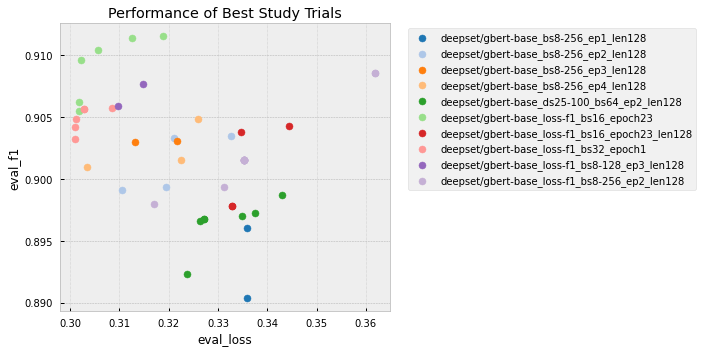

In [44]:
info.show_best_trials(name="gbert-base", figsize=(10,5));

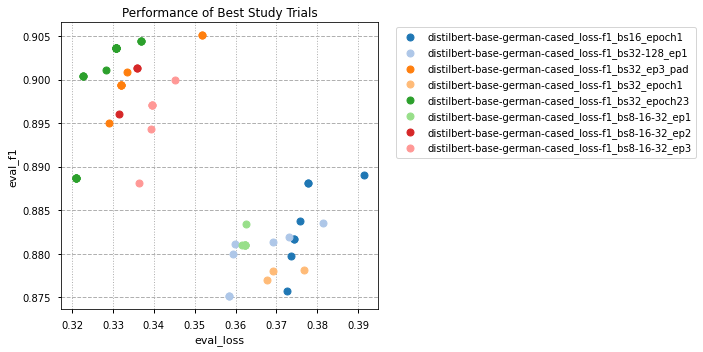

In [8]:
info.show_best_trials(name="distilbert-base", figsize=(10,5));

## Investigate a Study in Details

In [10]:
# study = "distilbert-base-german-cased_loss-f1_bs32-128_ep1"
study = "distilbert-base-german-cased_loss-f1_bs8-16-32_ep2"
# study = "distilbert-base-german-cased_loss-f1_bs32_epoch23"
# study = "deepset/gbert-base_loss-f1_bs16_epoch23_len128"

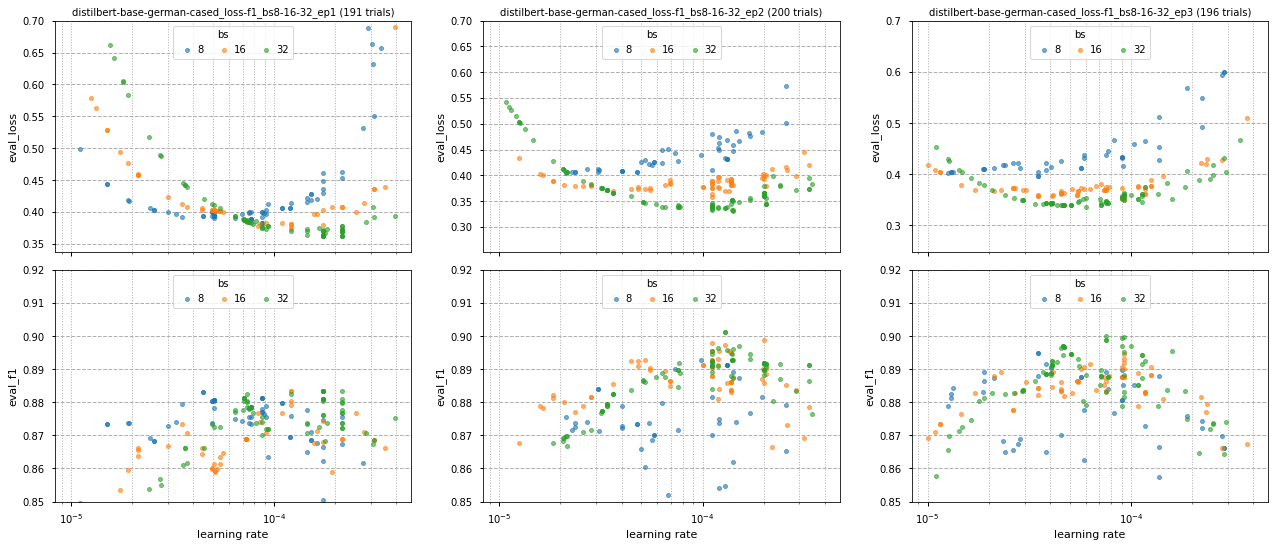

In [11]:
info.plot_lr_metrics(["distilbert-base-german-cased_loss-f1_bs8-16-32_ep1",
                      "distilbert-base-german-cased_loss-f1_bs8-16-32_ep2",
                      "distilbert-base-german-cased_loss-f1_bs8-16-32_ep3",
                      ], group_by="bs", figsize=(18,8));

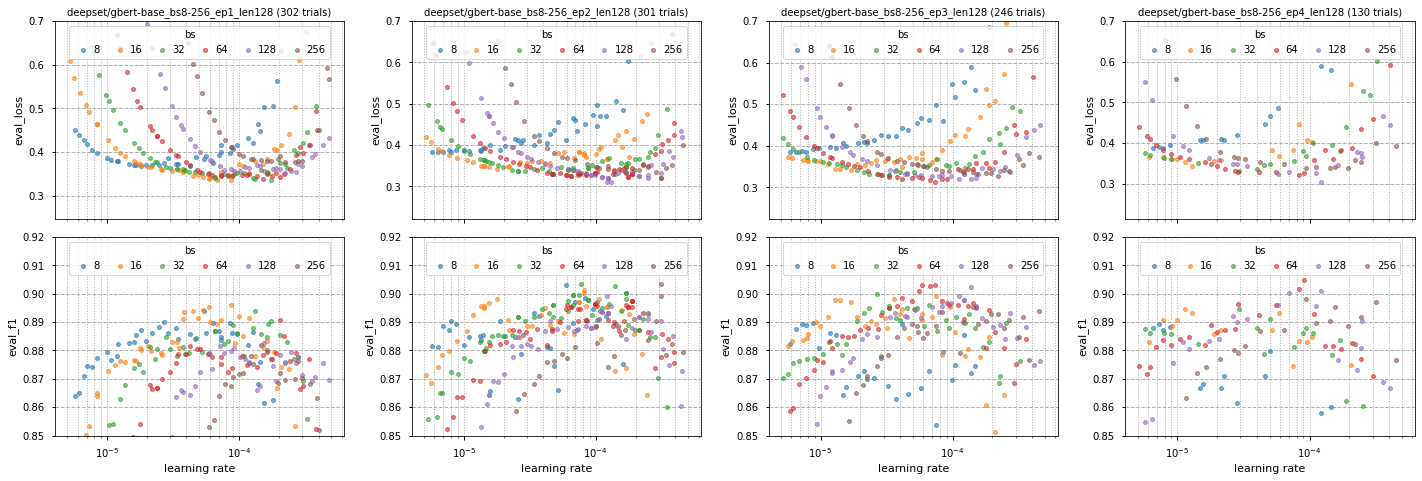

In [12]:
info.plot_lr_metrics(["deepset/gbert-base_bs8-256_ep1_len128",
                      "deepset/gbert-base_bs8-256_ep2_len128",
                      "deepset/gbert-base_bs8-256_ep3_len128",
                      "deepset/gbert-base_bs8-256_ep4_len128",
                      ], group_by="bs", figsize=(20,7), metrics=["eval_loss", "eval_f1"]);

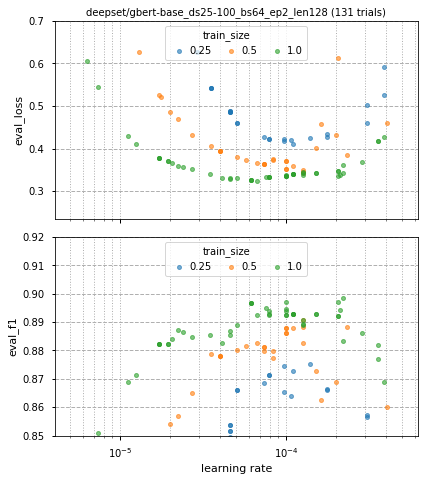

In [13]:
info.plot_lr_metrics(["deepset/gbert-base_ds25-100_bs64_ep2_len128",
                      ], group_by="train_size", figsize=(6,7), metrics=["eval_loss", "eval_f1"]);

In [14]:
display(info.get_best_trials("deepset/gbert-base_loss-f1_bs8-128_ep3_len128"))
display(info.get_best_trials("deepset/gbert-base_loss-f1_bs8-256_ep2_len128"))

,start,eval_loss,eval_acc,eval_f1,eval_precision,eval_recall,eval_mcc,eval_runtime,eval_samples_per_second,eval_steps_per_second,learning_rate,epochs,bs,weight_decay
54,2022-01-23,0.309711,0.909533,0.905857,0.905773,0.906911,0.896490,5.1346,200.212,25.124,0.000060,3,64,0.001069
264,2022-01-25,0.314870,0.910506,0.907684,0.906755,0.909598,0.897623,4.9542,207.503,26.039,0.000065,3,64,0.001339


,start,eval_loss,eval_acc,eval_f1,eval_precision,eval_recall,eval_mcc,eval_runtime,eval_samples_per_second,eval_steps_per_second,learning_rate,epochs,bs,weight_decay
85,2022-01-26,0.335222,0.904669,0.901520,0.898533,0.905863,0.890966,4.9754,206.617,25.928,0.000146,2,64,0.002328
117,2022-01-26,0.335222,0.904669,0.901520,0.898533,0.905863,0.890966,5.1859,198.229,24.875,0.000146,2,64,0.002328
119,2022-01-26,0.361898,0.912451,0.908605,0.910558,0.908042,0.899721,5.1726,198.741,24.939,0.000071,2,16,0.001356
133,2022-01-26,0.335222,0.904669,0.901520,0.898533,0.905863,0.890966,5.1708,198.808,24.948,0.000146,2,64,0.002328
181,2022-01-27,0.335222,0.904669,0.901520,0.898533,0.905863,0.890966,5.3058,193.751,24.313,0.000146,2,64,0.002328
189,2022-01-27,0.335222,0.904669,0.901520,0.898533,0.905863,0.890966,5.2836,194.564,24.415,0.000146,2,64,0.002328
215,2022-01-27,0.361898,0.912451,0.908605,0.910558,0.908042,0.899721,5.2532,195.690,24.556,0.000071,2,16,0.001356
216,2022-01-27,0.335222,0.904669,0.901520,0.898533,0.905863,0.890966,5.2499,195.814,24.572,0.000146,2,64,0.002328
222,2022-01-27,0.335222,0.904669,0.901520,0.898533,0.905863,0.890966,5.2100,197.312,24.760,0.000146,2,64,0.002328
224,2022-01-27,0.317087,0.902724,0.897933,0.898965,0.898459,0.888658,5.2210,196.898,24.708,0.000162,2,64,0.002328


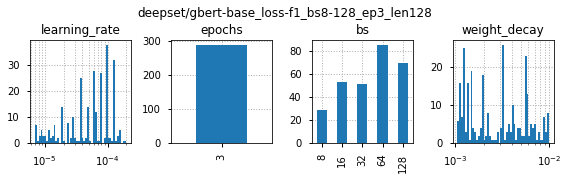

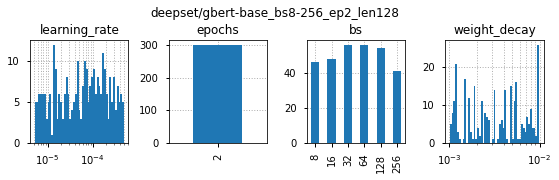

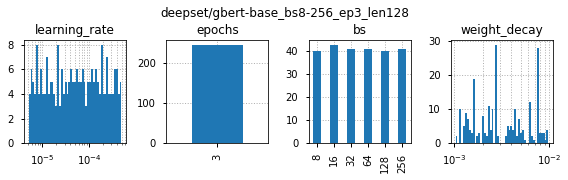

In [15]:
# info.plot_param_dist("deepset/gbert-base_loss-f1_bs8-256_ep2_len128", figsize=(8,2.5))
info.plot_param_dist("deepset/gbert-base_loss-f1_bs8-128_ep3_len128", figsize=(8,2.5))
info.plot_param_dist("deepset/gbert-base_bs8-256_ep2_len128", figsize=(8,2.5))
info.plot_param_dist("deepset/gbert-base_bs8-256_ep3_len128", figsize=(8,2.5))

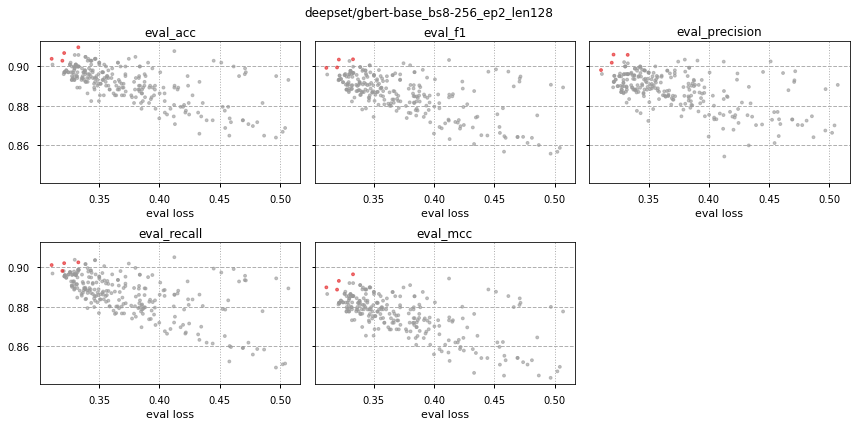

In [16]:
info.show_trial_metrics("deepset/gbert-base_bs8-256_ep2_len128", figsize=(12,6))

## Learning Curves

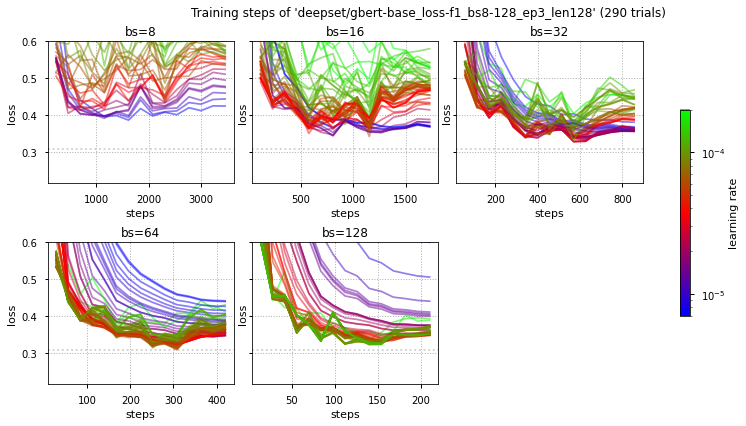

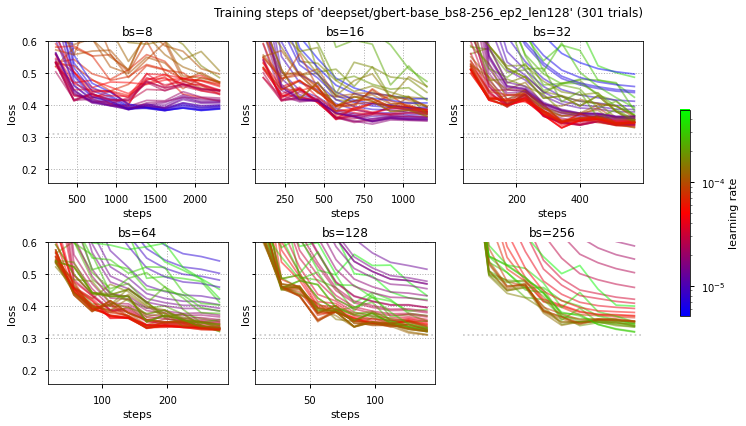

In [17]:
info.plot_training_steps("deepset/gbert-base_loss-f1_bs8-128_ep3_len128", figsize=(12,6))
info.plot_training_steps("deepset/gbert-base_bs8-256_ep2_len128", figsize=(12,6))

---
## Test dataset

## Best Results of Studies

In [22]:
stats = []
attrs = []
params = []
for s in optuna.get_all_study_summaries(storage):
    study = optuna.load_study(s.study_name, storage)
    for i, t in enumerate(study.best_trials):
        stats.append({"study_name": s.study_name,
                      "start": t.datetime_start.date(),
                    #   "best_count": i+1,
                      "trial_number": t.number,
                      })
        ua = t.user_attrs
        if "eval_result" in ua.keys():
            ua = ua["eval_result"]
        attrs.append(ua)
        params.append(t.params)

best_trials_df = pd.concat([pd.DataFrame(stats),
                            pd.DataFrame(attrs),
                            pd.DataFrame(params)], axis=1)
best_trials_df.drop(inplace=True, columns = [c for c in best_trials_df.columns if "per_second" in c])
best_trials_df.drop(inplace=True, columns = ["epoch"])
best_trials_df.rename(inplace=True, columns = {"num_train_epochs": "epochs",
                                               "per_device_train_batch_size": "bs"})
best_trials_df.sort_values(["study_name", "eval_loss"])

,study_name,start,trial_number,eval_loss,eval_acc,eval_f1,eval_precision,eval_recall,eval_mcc,eval_runtime,learning_rate,epochs,bs,weight_decay,batch_size,data_collator,max_seq_length,model,train_size
111,deepset/gbert-base_bs8-256_ep1_len128,2022-02-01,100,0.335854,0.893969,0.890390,0.891540,0.890292,0.878630,4.9215,0.000175,1,NaN,0.005459,32.0,False,128.0,deepset/gbert-base,1.0
112,deepset/gbert-base_bs8-256_ep1_len128,2022-02-01,208,0.335899,0.898833,0.896065,0.897299,0.895779,0.884218,4.9544,0.000087,1,NaN,0.003744,16.0,False,128.0,deepset/gbert-base,1.0
101,deepset/gbert-base_bs8-256_ep2_len128,2022-01-29,270,0.310619,0.903696,0.899112,0.897997,0.901044,0.889756,5.0254,0.000122,2,128.0,0.004156,NaN,NaN,NaN,NaN,NaN
100,deepset/gbert-base_bs8-256_ep2_len128,2022-01-29,258,0.319497,0.902724,0.899308,0.901721,0.898068,0.888601,5.0152,0.000311,2,256.0,0.001513,NaN,NaN,NaN,NaN,NaN
99,deepset/gbert-base_bs8-256_ep2_len128,2022-01-28,225,0.320985,0.906615,0.903306,0.905823,0.901986,0.893027,5.0684,0.000311,2,256.0,0.003689,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,distilbert-base-german-cased_loss-f1_bs8-16-32...,2022-01-18,162,0.339352,0.894942,0.894351,0.892596,0.896577,0.879744,6.9281,0.000046,3,32.0,0.001271,NaN,NaN,NaN,NaN,NaN
62,distilbert-base-german-cased_loss-f1_bs8-16-32...,2022-01-17,49,0.339605,0.897860,0.897119,0.894899,0.899849,0.883101,6.8950,0.000046,3,32.0,0.001453,NaN,NaN,NaN,NaN,NaN
63,distilbert-base-german-cased_loss-f1_bs8-16-32...,2022-01-17,54,0.339605,0.897860,0.897119,0.894899,0.899849,0.883101,6.8839,0.000046,3,32.0,0.001453,NaN,NaN,NaN,NaN,NaN
66,distilbert-base-german-cased_loss-f1_bs8-16-32...,2022-01-18,202,0.339605,0.897860,0.897119,0.894899,0.899849,0.883101,7.0658,0.000046,3,32.0,0.001453,NaN,NaN,NaN,NaN,NaN


In [26]:
# optuna.delete_study('deepset/gbert-base_bs64_ep2_len128-512', storage)
[s.study_name for s in optuna.get_all_study_summaries(storage)]

['deepset/gelectra-base_loss-f1_bs16_epoch234',
 'distilbert-base-german-cased_loss-f1_bs32_epoch23',
 'distilbert-base-german-cased_loss-f1_bs32_epoch1',
 'deepset/gbert-base_loss-f1_bs32_epoch1',
 'deepset/gbert-base_loss-f1_bs16_epoch23',
 'deepset/gbert-base_loss-f1_bs16_epoch23_len128',
 'deepset/gelectra-large_loss-f1_bs16_epoch1_len128',
 'distilbert-base-german-cased_loss-f1_bs16_epoch1',
 'distilbert-base-german-cased_loss-f1_bs8-16-32_ep1',
 'distilbert-base-german-cased_loss-f1_bs8-16-32_ep2',
 'distilbert-base-german-cased_loss-f1_bs8-16-32_ep3',
 'distilbert-base-german-cased_loss-f1_bs32-128_ep1',
 'distilbert-base-german-cased_loss-f1_bs32_ep3_pad',
 'deepset/gbert-base_loss-f1_bs8-128_ep3_len128',
 'deepset/gbert-base_loss-f1_bs8-256_ep2_len128',
 'deepset/gbert-base_bs8-256_ep2_len128',
 'deepset/gbert-base_bs8-256_ep3_len128',
 'deepset/gbert-base_ds25-100_bs64_ep2_len128',
 'deepset/gbert-base_bs64_ep2_len128-512',
 'deepset/gbert-base_bs8-256_ep1_len128',
 'deepset/

## Load Study

In [27]:
# study = optuna.load_study('deepset/gbert-base_bs16_epoch234', storage)
# study = optuna.load_study('deepset/gelectra-base_loss-f1_bs16_epoch234', storage)
# study = optuna.load_study('distilbert-base-german-cased_loss-f1_bs32_epoch1', storage)
# study = optuna.load_study('distilbert-base-german-cased_loss-f1_bs16_epoch1', storage)
# study = optuna.load_study('distilbert-base-german-cased_loss-f1_bs32_epoch23', storage)
# study = optuna.load_study('distilbert-base-german-cased_loss-f1_bs8-16-32_ep1', storage)
# study = optuna.load_study('distilbert-base-german-cased_loss-f1_bs32-128_ep1', storage)
# study = optuna.load_study('distilbert-base-german-cased_loss-f1_bs32_ep3_pad', storage)
# study = optuna.load_study('deepset/gbert-base_loss-f1_bs32_epoch1', storage)
# study = optuna.load_study('deepset/gbert-base_loss-f1_bs16_epoch23', storage)
# study = optuna.load_study('deepset/gbert-base_loss-f1_bs16_epoch23_len128', storage)
study = optuna.load_study('deepset/gbert-base_loss-f1_bs8-128_ep3_len128', storage)
# study = optuna.load_study('deepset/gelectra-large_loss-f1_bs16_epoch1_len128', storage)

## Hyperparameter Overview

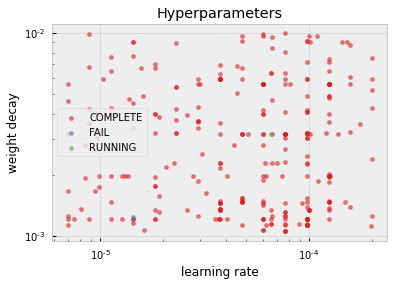

In [28]:
from optuna.trial import TrialState

params = []
for t in study.get_trials(deepcopy=False):
    params.append({"state": str(t.state).split('.')[1], **t.params})
state_params_df = pd.DataFrame(params)

pal = sns.color_palette("Set1")

field="state"
for i, f in enumerate(sorted(state_params_df[field].unique())):
    df = state_params_df[lambda x: x[field] == f]
    plt.scatter(df.learning_rate, df.weight_decay, alpha=0.6, s=16, label=f, color=pal[i])
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.title("Hyperparameters")
plt.xlabel("learning rate")
plt.ylabel("weight decay");

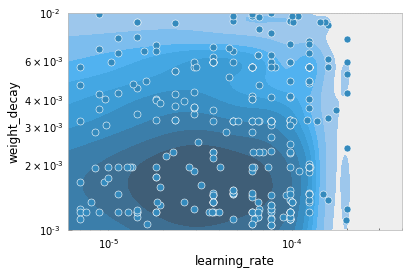

In [51]:
param_df = pd.DataFrame([t.params for t in study.get_trials(deepcopy=False)])
g = sns.kdeplot(x=param_df.learning_rate, y=param_df.weight_decay, shade=True)
g = sns.scatterplot(x=param_df.learning_rate, y=param_df.weight_decay)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlim((6e-6, 4e-4))
plt.ylim((1e-3, 1e-2));

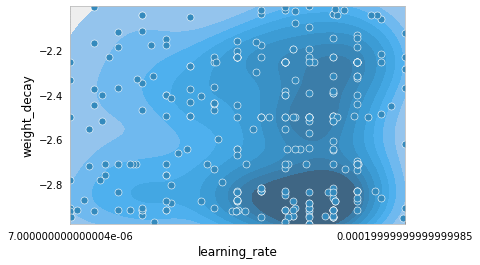

In [53]:
param_df = pd.DataFrame([t.params for t in study.get_trials(deepcopy=False)])
g = sns.kdeplot(x=np.log10(param_df.learning_rate), y=np.log10(param_df.weight_decay), shade=True)
g = sns.scatterplot(x=np.log10(param_df.learning_rate), y=np.log10(param_df.weight_decay))
# plt.gca().set_xscale('log')
# plt.gca().set_yscale('log')
plt.xticks([min(np.log10(param_df.learning_rate)), max(np.log10(param_df.learning_rate))], [min(param_df.learning_rate), max(param_df.learning_rate)])
plt.xlim((min(np.log10(param_df.learning_rate)), max(np.log10(param_df.learning_rate))))
plt.ylim((min(np.log10(param_df.weight_decay)), max(np.log10(param_df.weight_decay))));

In [54]:
print([min(np.log10(param_df.learning_rate)), max(np.log10(param_df.learning_rate))], [min(param_df.learning_rate), max(param_df.learning_rate)])

[-5.154901959985743, -3.698970004336019] [7.000000000000004e-06, 0.00019999999999999985]


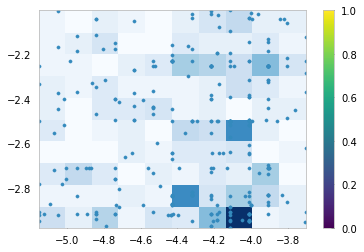

In [31]:
g = plt.hist2d(x=np.log10(param_df.learning_rate), y=np.log10(param_df.weight_decay), cmap="Blues");
plt.scatter(x=np.log10(param_df.learning_rate), y=np.log10(param_df.weight_decay), s=10);
plt.colorbar()
# plt.xscale("log")

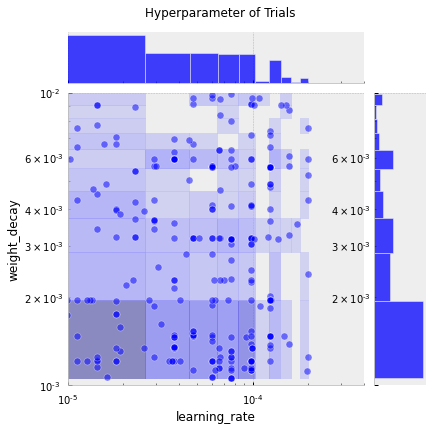

In [30]:
g = sns.jointplot(x=param_df.learning_rate, y=param_df.weight_decay, kind='hist', xlim=(1e-5, 4e-4), ylim=(1e-3, 1e-2), color="b")
g.plot_joint(sns.scatterplot, color="b", zorder=1, alpha=0.5)
g.ax_joint.set_xscale('log')
g.ax_joint.set_yscale('log')
# g.fig.tight_layout()
g.ax_joint.collections[0].set_alpha(0.6) # tile alpha
g.fig.suptitle("Hyperparameter of Trials")
g.fig.subplots_adjust(top=0.92)
plt.xlabel("learning rate")
plt.ylabel("weight decay");

## Analyze Zombie Trials

Interupted trials left in RUNNING state.

In [32]:
from optuna.trial import TrialState

running_trials = study.get_trials(states=[TrialState.RUNNING])

pd.DataFrame([t.params for t in running_trials])

,learning_rate,num_train_epochs,per_device_train_batch_size,weight_decay
0,0.000065,3,16,0.003177


## Analyze Complete Trials

In [33]:
from optuna.trial import TrialState

complete_trials = study.get_trials(states=[TrialState.COMPLETE])

def get_metrics(trial):
    attrs = trial.user_attrs
    if "eval_result" in attrs.keys():
        attrs = attrs["eval_result"]
    return attrs

# compile trial details for further analysis
if len(complete_trials) > 0:
    index = [t.number for t in complete_trials]
    trial_metrics_df = pd.DataFrame([get_metrics(t) for t in complete_trials], index=index)
    trial_params_df = pd.DataFrame([t.params for t in complete_trials], index=index)
    trial_df = pd.concat([trial_params_df, trial_metrics_df], axis=1).sort_values("eval_loss", ascending=True)
    best = [t.number for t in study.best_trials]
    trial_df["best"] = trial_df.index.isin(best)
    main_metric = "eval_loss"
    trial_params_df[main_metric] = trial_metrics_df[main_metric]
    display(trial_df.head(10))
else:
    raise ValueError("there must be at least one complete trial")

,learning_rate,num_train_epochs,per_device_train_batch_size,weight_decay,eval_loss,eval_acc,eval_f1,eval_precision,eval_recall,eval_mcc,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,best
54,0.000060,3,64,0.001069,0.309711,0.909533,0.905857,0.905773,0.906911,0.896490,5.1346,200.212,25.124,3.0,True
274,0.000060,3,64,0.001959,0.310844,0.905642,0.902247,0.901388,0.904139,0.892058,4.9149,209.158,26.246,3.0,False
218,0.000060,3,64,0.005594,0.312473,0.906615,0.903254,0.902646,0.904547,0.893102,4.9511,207.633,26.055,3.0,False
264,0.000065,3,64,0.001339,0.314870,0.910506,0.907684,0.906755,0.909598,0.897623,4.9542,207.503,26.039,3.0,True
183,0.000065,3,64,0.001145,0.314870,0.910506,0.907684,0.906755,0.909598,0.897623,4.9042,209.616,26.304,3.0,False
141,0.000077,3,64,0.001246,0.315081,0.901751,0.897011,0.897391,0.898469,0.887548,4.9630,207.134,25.993,3.0,False
245,0.000065,3,64,0.006376,0.316040,0.907588,0.904448,0.905446,0.904003,0.894148,5.0472,203.675,25.558,3.0,False
267,0.000065,3,64,0.006376,0.316040,0.907588,0.904448,0.905446,0.904003,0.894148,4.9634,207.116,25.990,3.0,False
275,0.000060,3,64,0.003177,0.316852,0.905642,0.902274,0.901423,0.904340,0.892089,4.9076,209.470,26.286,3.0,False
277,0.000081,3,64,0.005621,0.317236,0.902724,0.899397,0.899636,0.900329,0.888616,4.9283,208.593,26.176,3.0,False


In [34]:
# import plotly.express as px

# fig = px.parallel_coordinates(trial_df[trial_params_df.columns], color=main_metric, 
#                              color_continuous_scale=px.colors.sequential.Oryel)
# fig.update_layout(autosize=False, width=700, height=350)
# fig.show()

In [35]:
# fig = optuna.visualization.plot_parallel_coordinate(study, target=lambda trial: trial.user_attrs["eval_loss"], target_name="loss")
# fig.update_layout(autosize=False, width=700, height=350)
# fig.show()

In [36]:
# optuna.visualization.plot_contour(study)

In [37]:
# # from optuna.visualization import plot_param_importances
# from optuna.visualization.matplotlib import plot_param_importances

# fig = plot_param_importances(
#     study, target=lambda t: t.values[0], target_name="eval_loss"
# )
# # fig.update_layout(autosize=False, width=800, height=350)
# # fig.show()

In [38]:
def get_loss(trial):
    """Handle different data format versions"""
    if "eval_result" in trial.user_attrs.keys():
        return trial.user_attrs["eval_result"]["eval_loss"]
    else:
        return trial.user_attrs["eval_loss"]

In [39]:
# fig = optuna.visualization.plot_slice(study, target=get_loss, target_name="loss")
# fig.update_layout(autosize=False, width=900, height=350)
# fig.show()

## Single Trial - Extract data logged during train

In [40]:
running_trials = [t for t in study.get_trials() if t.state==TrialState.RUNNING]
data = complete_trials[-1].user_attrs
if "eval_result" in data.keys():
    log_df = pd.DataFrame(data.values(), index=data.keys())[lambda x: x.index != "eval_result"]
    log_df.index = log_df.index.astype(int)
    log_df.sort_index(inplace=True)
    display(log_df)

,eval_loss,eval_acc,eval_f1,eval_precision,eval_recall,eval_mcc,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,lr
28,0.573222,0.827821,0.819543,0.845398,0.812519,0.805790,4.9613,207.205,26.001,0.19,0.000091
56,0.439471,0.859922,0.857084,0.862250,0.859070,0.841123,4.9234,208.799,26.201,0.39,0.000085
84,0.390443,0.875486,0.869493,0.870234,0.872798,0.857740,4.9188,208.994,26.226,0.58,0.000079
112,0.422539,0.863813,0.859187,0.866539,0.860881,0.845358,4.9324,208.418,26.154,0.78,0.000072
140,0.409612,0.874514,0.869307,0.868860,0.872499,0.856541,4.9166,209.088,26.238,0.97,0.000066
168,0.365343,0.881323,0.877870,0.878848,0.878975,0.864374,4.9047,209.594,26.301,1.17,0.000060
196,0.365726,0.888132,0.883512,0.880936,0.886854,0.872063,4.9204,208.927,26.217,1.36,0.000053
224,0.382641,0.886187,0.882604,0.880584,0.886990,0.869966,4.9324,208.416,26.153,1.55,0.000047
252,0.329445,0.903696,0.901101,0.904652,0.899415,0.889775,4.9184,209.012,26.228,1.75,0.000041
280,0.336241,0.903696,0.898058,0.899172,0.898490,0.889880,4.9425,207.991,26.100,1.94,0.000034


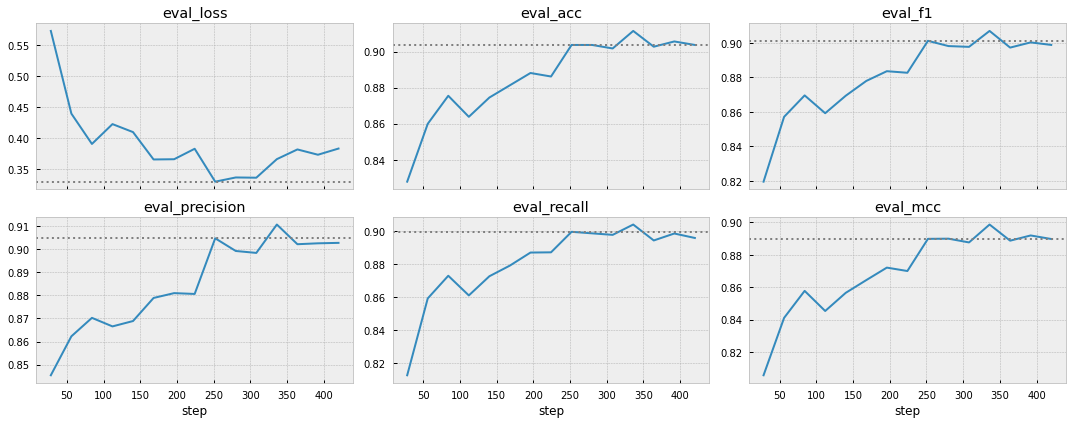

In [41]:
fig, axs = plt.subplots(2, 3, figsize=(15,6), sharex=True)

metrics = [c for c in log_df.columns if c.startswith("eval_")]

for col, ax in zip(metrics, axs.flatten()):
    log_df[col][0:-1].plot(ax=ax).axhline(log_df[col].values[-1], c="grey", linestyle=":")
    ax.set_title(col)
    ax.set_xlabel("step")
    # ax.grid(axis='y', linestyle='--', zorder=1)
    # ax.grid(axis='x', linestyle=':', zorder=1)

plt.tight_layout()

## Plot Learning Rate

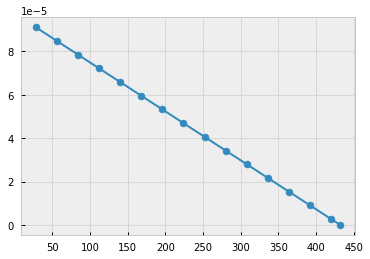

In [42]:
log_df["lr"].plot()
plt.scatter(log_df["lr"].index, log_df["lr"]);